[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1sto-bZsnwxEnyR3wJ0X2iwrh1C-QaTZZ?usp=sharing)

# About this notebook

In this notebook, we apply CIDRE to the original example code in order to replicate the original experiments and aid in validating the results.

**The purpose of this notebook is to simply demonstrate that the original CIDRE code is fully functional and has been replicated by a third party (myself, Gregory Pollard).**

# CITATION:

The code in this notebook and at its associated Github connection was entirely copied from the original CIDRE Github found [here](https://github.com/skojaku/cidre).


**Paper:** Detecting anomalous citation groups in journal networks

**Authors:** Kojaku, Sadamori and Livan, Giacomo and Masuda, Naoki

**Journal:** Sci. Rep.

**Publisher:** Nature Publishing Group

## Preparation

### Install CIDRE package

First, we install `cidre` package with `pip`:

In [1]:
!pip install cidre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 18.2 MB/s 
     |████████████████████████████████| 38.1 MB 117 kB/s 
     |████████████████████████████████| 13.1 MB 36.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
cidre 0.0.1 requires seaborn==0.11.1, but you have seaborn 0.11.2 which is incompatible.



### Loading libraries

Next, we load some libraries:

In [2]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

Finding communities requires the graph-tool package. This can be installed easily on Unix machines with:



```
conda install -c conda-forge graph-tool
```

Or, in Google Colab, we may use:

In [3]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Now, we must define the functions required for community detection with the graph-tool package.

In [4]:
import graph_tool.all as gt

def detect_community(A, K = None, **params):
    """Detect communities using the graph-tool package

    :param A: adjacency matrix
    :type A: scipy.csr_sparse_matrix
    :param K: Maximum number of communities. If K = None, the number of communities is automatically determined by graph-tool.
    :type K: int or None
    :param params: parameters passed to graph_tool.gt.minimize_blockmodel_dl
    """
    def to_graph_tool_format(adj, membership=None):
        g = gt.Graph(directed=True)
        r, c, v = sparse.find(adj)
        nedges = v.size
        edge_weights = g.new_edge_property("double")
        g.edge_properties["weight"] = edge_weights
        g.add_edge_list(
            np.hstack([np.transpose((r, c)), np.reshape(v, (nedges, 1))]),
            eprops=[edge_weights],
        )
        return g
    G = to_graph_tool_format(A)

    states = gt.minimize_blockmodel_dl(
        G,
        state_args=dict(eweight=G.ep.weight),
        multilevel_mcmc_args = {"B_max": A.shape[0] if K is None else K },
        **params
    )
    b = states.get_blocks()
    return np.unique(np.array(b.a), return_inverse = True)[1]

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo._cairo'
  warnings.warn(msg, RuntimeWarning)



# Journals of 2013 Example

We apply CIDRE as in the original experiments on the Microsoft Academic Graph Data set for journals of 2013.

In [17]:
# Data path
edge_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/edge-table-2013.csv"
node_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/community-label.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

## About this network

This network is a citation network of journals in 2013 constructed from Microsoft Academic Graph.
Each edge is weighted by the number of citations made to the papers in the prior two years.
The following are basic statistics of this network.

In [18]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

Number of nodes: 31385
Number of edges: 8038733
Average degree: 256.13
Max in-degree: 143633
Max out-degree: 228866
Maximum edge weight: 19792
Minimum edge weight: 1


## Communities

[In the original CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors identified the communities of journals using [graph-tool](https://graph-tool.skewed.de/). `node_table` contains the community membership of each journal, from which we prepare `group_membership` array as follows.

In [19]:
# Get the group membership
node2com = dict(zip(node_table["journal_id"], node_table["community_id"]))
group_membership = [node2com[node_labels[i]] for i in range(A.shape[0])]

## Detecting anomalous groups in the network

We detect the anomalous groups in the network:

In [20]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 16
Number of groups detected: 129


[In the orignal CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors omitted the groups that have within-group citations less than 50 because we expect that anomalous citation groups contain sufficiently many within-group citations, i.e., 

In [21]:
groups = [group for group in groups if group.get_num_edges()>=50]
len_groups = len(groups)

where `group.get.num_edges()` gives the sum of the weights of the non-self-loop edges within the group.

## Visualization

Let us visualize the groups detected by CIDRE. For expository purposes, we sample three groups to visualize uniformly at random.

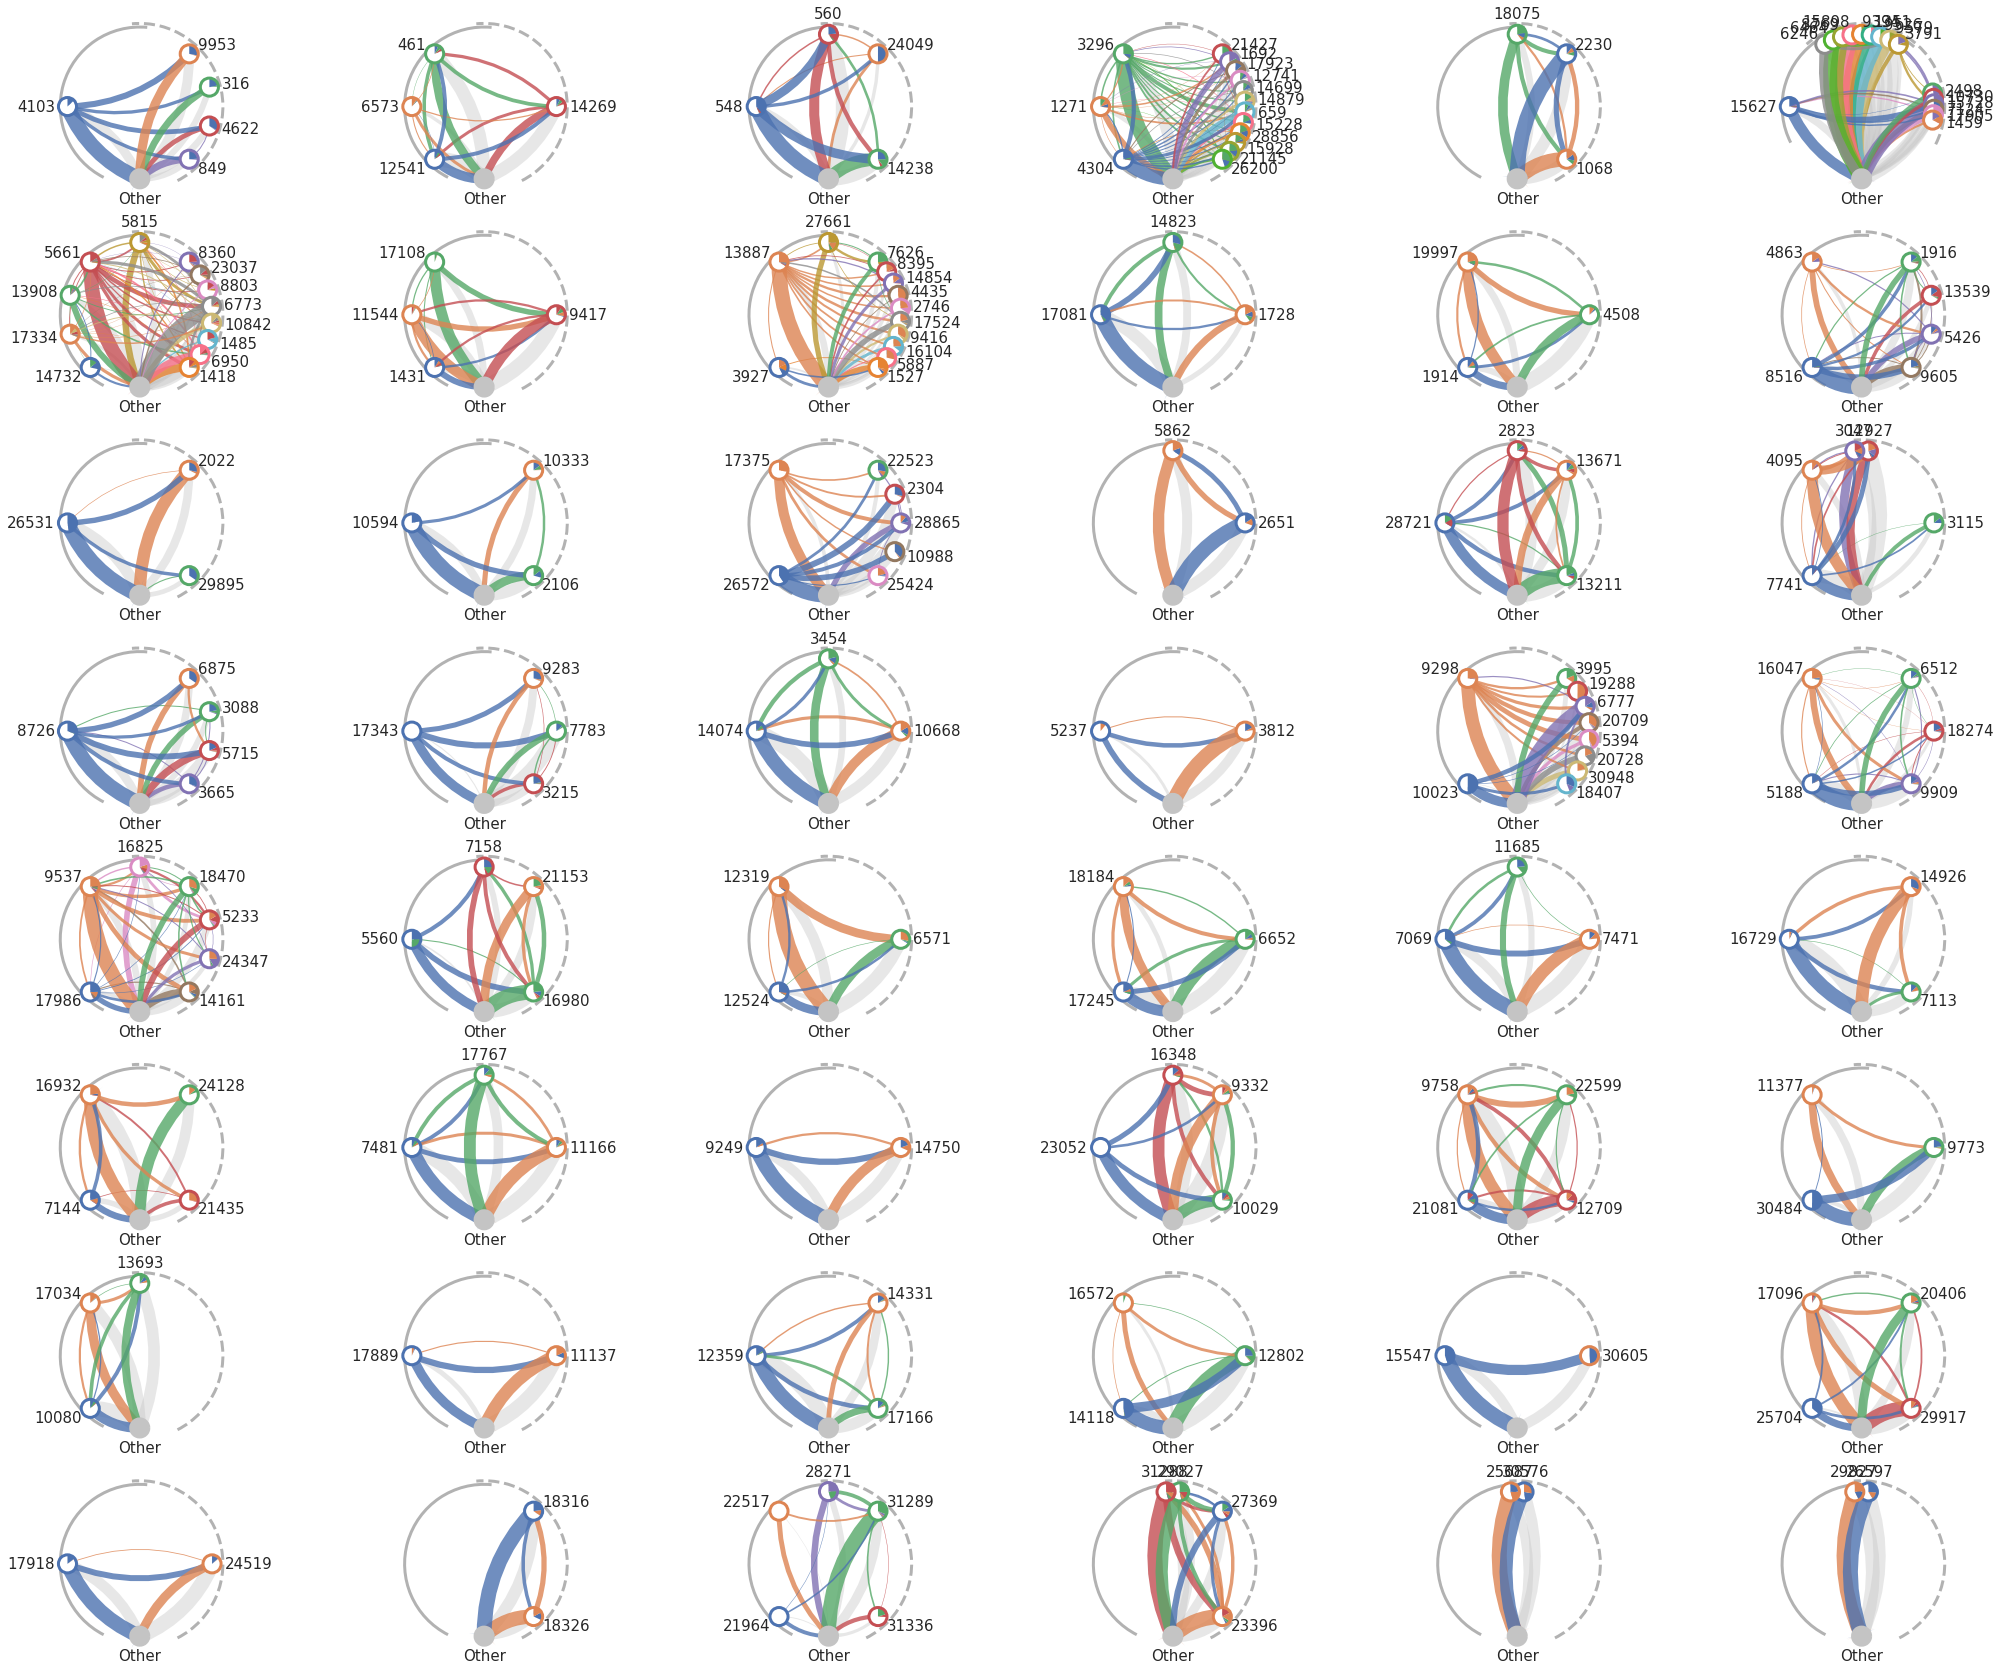

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 6,nrows = 8, figsize=(6 * 6, 30))

for i in range(len_groups):
    cidre.DrawGroup().draw(groups[i], ax = axes.flat[i])

The numbers beside the nodes are the IDs of the journals in the network. To show the journals' names, we do the following. 


First, we load node lables and make a dictionary that maps the ID of each node to the label:

In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/journal_names.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # Dictionary from MAG journal ID to the journal name

id2label = {k:journalid2label[v] for k, v in node_labels.items()} # This is a dictionary from ID to label, i.e., {ID:journal_name}

Then, give `id2label` to `cidre.DrawGroup.draw`, i.e.,  

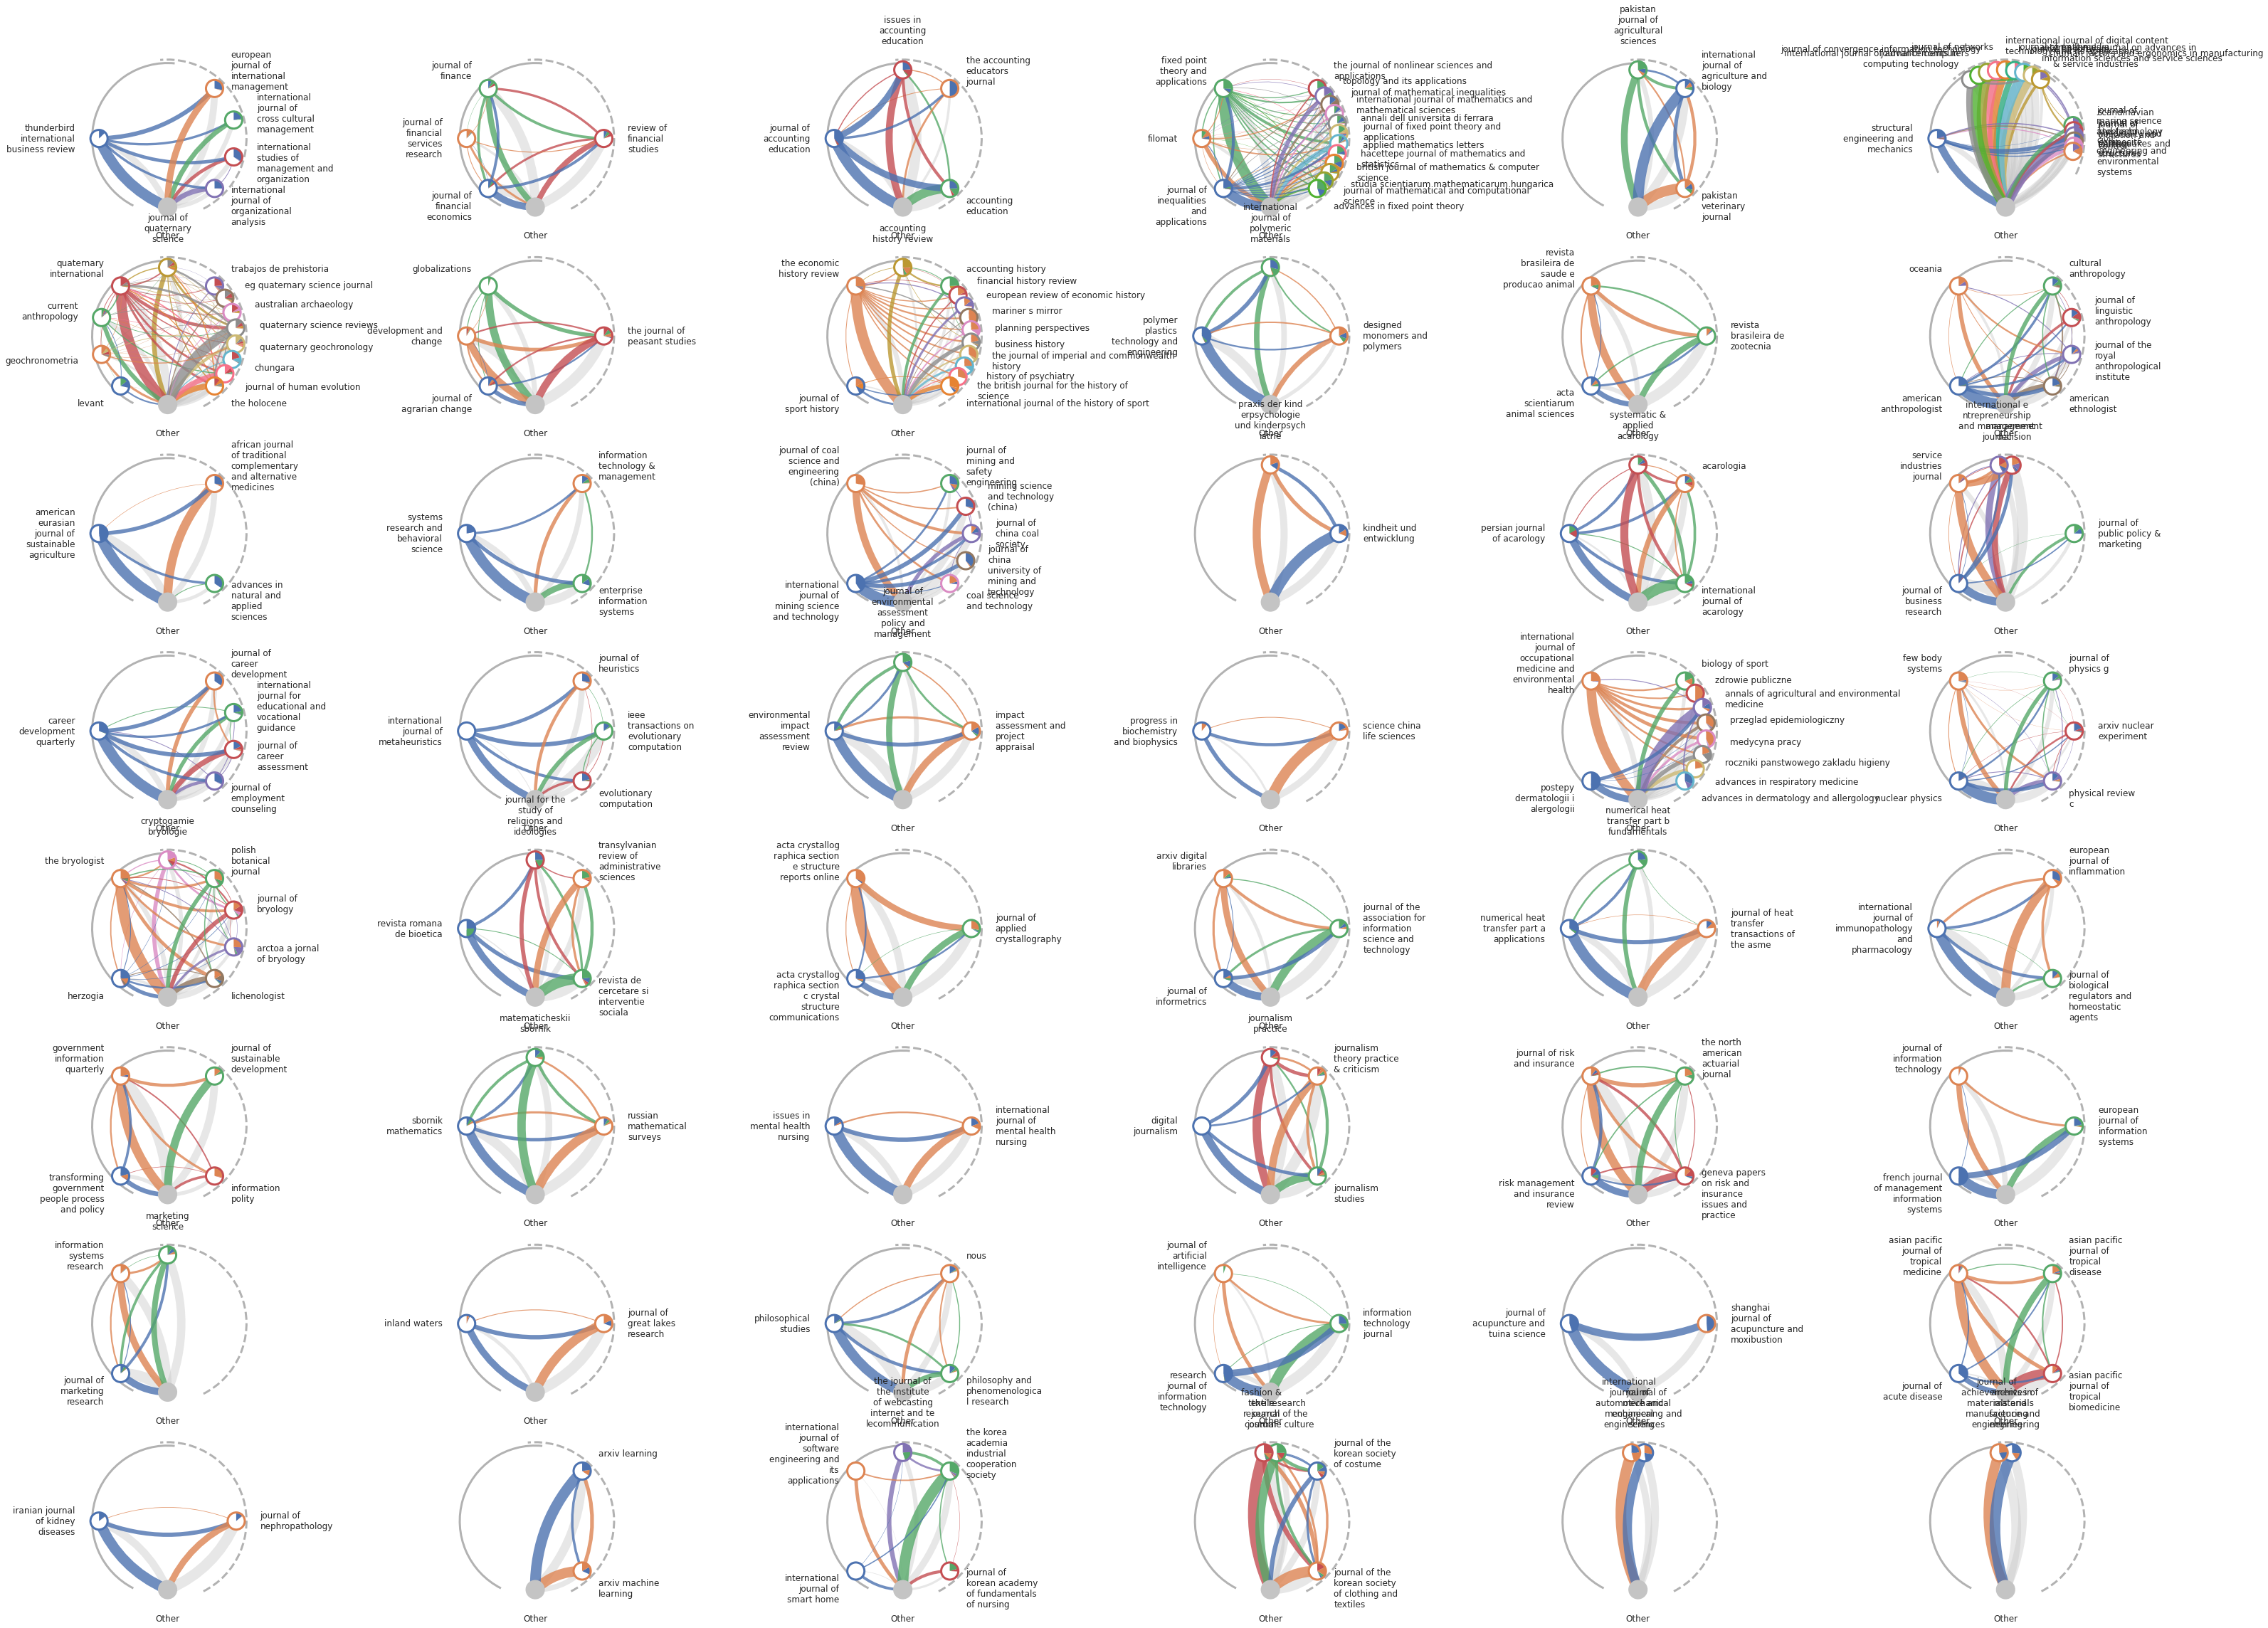

In [25]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 6,nrows = 8, figsize=(9 * 6, 40))

for i in range(48):
    plotter = cidre.DrawGroup()
    plotter.font_size = 12 # Font size
    plotter.label_node_margin = 0.7 # Margin between labels and node
    plotter.draw(groups[i], node_labels = id2label, ax = axes.flat[i])